# Null space: ambiguity in DRT estimation
This notebook illustrates an important concept in DRT inversion - the null space of the DRT matrix - and examines how it applies to DRT-DOP inversion. The script `DRT-DOP_separation.py` contains related examples.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

import hybdrt.plotting as hplt
from hybdrt.models import DRT, DiscreteElementModel

import fig_funcs as ff

%load_ext autoreload
%autoreload 2


In [5]:
# Set plot formatting
full_width, half_width, light_colors, base_colors, dark_colors = ff.set_plot_formatting()

data_kw = dict(facecolors='none', edgecolors=[0.1] * 3)

## The "nearly-null" space in DRT inversion

The null space of a matrix $A$ is the space of vectors $x$ for which $Ax=0$. When we perform conventional DRT inversion, we are solving the system $Ax=b$, where $A$ represents the DRT kernel, $b$ represents the data, and $x$ represents the DRT parameters. The true null space contains only the zero vector, but the “nearly-null” space – i.e. the space of DRT functions that result in impedance spectra that are close enough to zero as to be negligible relative to a measured spectrum - is infinitely large. 

This “nearly-null” space has crucial implications for DRT estimation from noisy impedance data. This is why DRT estimation from noisy impedance data is an ill-posed inversion problem, and why any DRT estimation algorithm must apply the principle of parsimony (most often through regularizing priors) to obtain sensible and consistent results. This has been thoroughly explored in the literature and is summarized nicely in http://dx.doi.org/10.1016/j.electacta.2015.03.123 and https://doi.org/10.1149/1945-7111/ab9c82. An example of how the “nearly-null” space affects DRT estimation, and how it can be mitigated with regularizing priors, is shown in the figure below. Although this ambiguity appears as a hindrance to DRT estimation, it is also the source of the utility of the DRT. The DRT is ambiguous because it makes no *a priori* prescription of a particular explanation for the data (in the form of a generative model). This is precisely why the DRT is versatile and powerful in cases when the true model for the system is not known. 


In [7]:
# Make ZARC model for nullspace demo
freq = np.logspace(6, -1, 71)
dem = DiscreteElementModel('R0-RQ1')
dem.parameter_values = np.array([
    1,
    1.0, np.log(1e-3), 0.7,
    # 1.0, np.log(1e-2), 0.7,
])

# Simulate noisy impedance
z_true = dem.predict_z(freq)

rng = np.random.default_rng(1489)
sigma = 0.0005
z_noise = rng.normal(0, sigma, len(z_true)) + 1j * rng.normal(0, sigma, len(z_true))
z_noisy = z_true + z_noise

In [3]:
# Create DRT instance
drt = DRT()

Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready


<IPython.core.display.Javascript object>


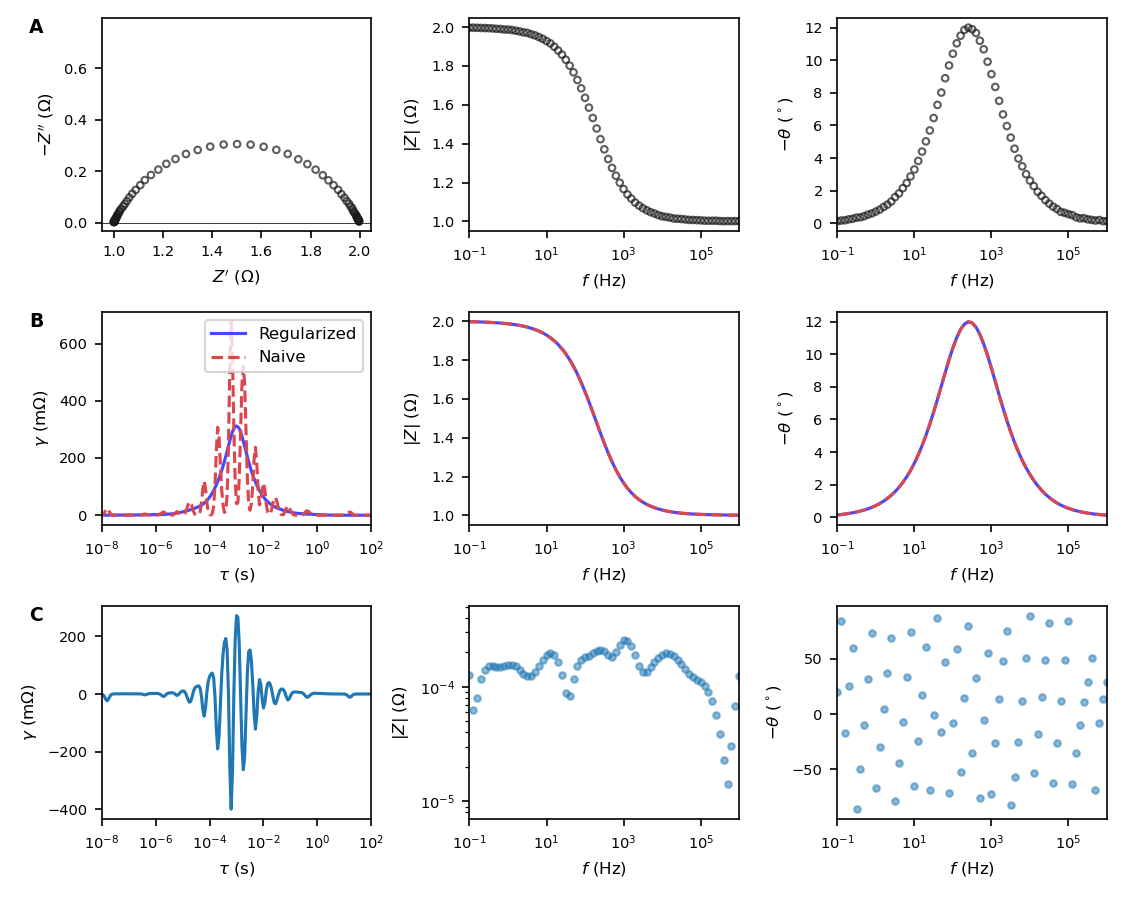

In [6]:
# Show how the nullspace of the conventional DRT affects inversion
fig, axes = plt.subplots(3, 3, figsize=(7.5, 6), sharex=False)

axes[0, 1].get_shared_x_axes().join(*axes[:, 1:].ravel())

# Plot data
hplt.plot_eis((freq, z_noisy), axes=axes[0], **data_kw, alpha=0.7, bode_kw=dict(log_mod=False))
    
# Regularized fit
drt.fit_eis(freq, z_noisy, l2_lambda_0=0)

# Unpenalized (naive) fit
drt_up = drt.copy()
drt.fit_eis(freq, z_noisy)

# Plot each fit
fits = [drt, drt_up]
ls = ['-', '--']
ms = ['', '']
for i, (fit, label) in enumerate(zip(fits, ['Regularized', 'Naive'])):
    fit.plot_distribution(ax=axes[1, 0], label=label, ls=ls[i], 
                          c=light_colors[i], marker=ms[i])
    fit.plot_eis_fit(axes=axes[1, 1:], plot_data=False, plot_type='bode', 
                     c=light_colors[i], marker=ms[i], ls=ls[i],
                     label=label, 
                     bode_cols=['Zmod', 'Zphz'], bode_kw=dict(log_mod=False))
    
axes[1, 0].legend()

    
# Plot diff
x = drt.qphb_history[-1]['x']
x_up = drt_up.qphb_history[-1]['x']


# fig, axes = plt.subplots(1, 3, figsize=(8, 3))
# ax = drt.plot_distribution(x=drt.qphb_history[-1]['x'])
# drt.plot_distribution(x=drt_up.qphb_history[-1]['x'], ax=ax)
drt.plot_distribution(x=x - x_up, ax=axes[2, 0])

z_diff = drt.predict_z(freq, x=x - x_up)
hplt.plot_bode((freq, z_diff), axes=axes[2, 1:], scale_prefix='')

for ax in axes [0, 1:]:
    ax.set_xlim(1e-1, 1e6)
    
for ax in axes[1:, 0]:
    ax.set_xlim(1e-8, 1e2)
    
ff.add_letters(axes[:, 0], loc=(-0.27, 1.))
    
# ff.savefig(fig, 'Nullspace_RQ_example')

Figure 1. Example of how the “nearly-null” space affects DRT estimation. (A) Simulated impedance spectrum of a ZARC element with random noise. (B) Left: DRT estimates obtained from the simulated spectrum without regularization (“Naïve”) and with regularization. Right: Bode plots of the impedance spectrum corresponding to each DRT estimate. (C) Left: The difference between the regularized and naïve DRT estimates. Right: Bode plot of the impedance spectrum of the DRT difference. The impedance magnitude arising from the DRT difference is negligible relative to the measured impedance, indicating that the difference function belongs to the “nearly-null” space of the DRT matrix.

## The nearly-null space in DRT-DOP inversion

Let us first consider the DOP in isolation. Similar to the unconstrained DRT, the null space of the DOP itself (without a DRT component) contains only the zero vector, but the “nearly-null” space is infinitely large because of the integration of the DOP times the phasance kernel. This can be handled with regularizing priors in the same manner as the DRT. However, the phasance kernel function of the DOP is more amenable to resolution than the RC kernel function of the DRT. Consider two delta functions in the DOP, located at ν and ν+Δν. The difference between their impedance contributions, (jω)^(ν+Δν)-(jw)^ν, grows with ω^ν, implying that measurements at very low frequencies (for ν<0, i.e. pseudo-capacitive) or very high frequencies (for ν>0, i.e. pseudo-inductive) are powerful for reducing ambiguity in the DOP.

When the DOP is placed in series with the DRT, producing the matrix given in Equation S62, the true null space expands. This is because the impedance of a constant-phase element (CPE) can be described exactly by the DRT or the DOP. Although we are unaware of a closed-form analytical expression for the equivalent DRT of the CPE, Boukamp derived an expression for the equivalent DRT of the finite-length Warburg element (https://doi.org/10.1016/j.electacta.2017.08.154), which suggests that equivalent DRT functions also exist for  the CPE (this inference is also supported by the example given below). Thus, for any DOP function described by the vector x_DOP, there exists a DRT function described by the vector x_DRT such that A_DOP x_DOP=A_DRT x_DRT, where A_DOP and A_DRT represent the DOP and DRT matrices, respectively (Equations S60 and S51). However, we note that the inverse is not true: for any DRT function, there does not exist a DOP function satisfying A_DOP x_DOP=A_DRT x_DRT unless the DRT function exactly describes a CPE or phasance. In other words, the DRT can describe any impedance spectrum that the DOP can describe, but the DOP in general cannot describe any impedance spectrum that the DRT can describe (the DOP is less flexible than the DRT).

From a purely mathematical perspective, this certainly indicates indeterminacy in the solution to the DRT-DOP model. However, from perspectives of both physical parsimony and information theory, a “most sensible” solution becomes increasingly clear as more data is collected. As an example, consider the semi-infinite Warburg impedance (equivalent to the CPE with n=0.5). Suppose that we measure impedance spectra to minimum frequencies (fmin) of 100 Hz, 1 Hz, and 10 mHz (Figure 2A below). For each spectrum, we fit the data with either a pure DRT model or a pure DOP model. When the pure DRT is applied, a series of exponentially growing peaks is required to describe the Warburg impedance (Figure 2B below). As we measure to lower frequencies, this series of peaks must extend to longer timescales and exponentially larger magnitudes. In other words, the DRT becomes an increasingly complex and thus increasingly implausible explanation for the data. In contrast, when the pure DOP is applied, a single peak at -θ=45° is sufficient to describe the Warburg impedance regardless of the frequency range (FIgure 2C below). Therefore, the principle of parsimony (from both physicochemical and statistical perspectives) very strongly favors the simple DOP over the complex DRT as more data is collected. 


In [8]:
# DRT: extended basis to capture long-timescale peaks
drt_cpe = DRT(fixed_basis_tau=np.logspace(-8, 5, 131))

# DOP: limit DRT range and use delta function to get exact representation
dop_cpe = DRT(fixed_basis_tau=np.logspace(-8, -5, 31), fit_dop=True, nu_basis_type='delta',
              fixed_basis_nu=np.array([-0.5, -0.1])
              )

drt_fits = []
dop_fits = []
f_mins = [100, 1, 0.01]
for f_min in f_mins:
    print(f_min)
    lf = np.log10(f_min)
    f_cpe = np.logspace(6, lf, int(10 * (6 - lf) + 1))
    z_cpe = (1j * f_cpe * 2 * np.pi) ** -0.5

    # DRT: unregularized fit to capture all peaks
    drt_cpe.fit_eis(f_cpe, z_cpe, l2_lambda_0=1e-6)
    
    # DOP: normal fit, only one peak
    dop_cpe.fit_eis(f_cpe, z_cpe) 

    
    drt_fits.append(drt_cpe.copy())
    dop_fits.append(dop_cpe.copy())


Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready
Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready
100
1


C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\drt1d.py:982: UserWarning: Solution did not converge within 50 iterations
  warnings.warn(f'Solution did not converge within {max_iter} iterations')


0.01


<IPython.core.display.Javascript object>


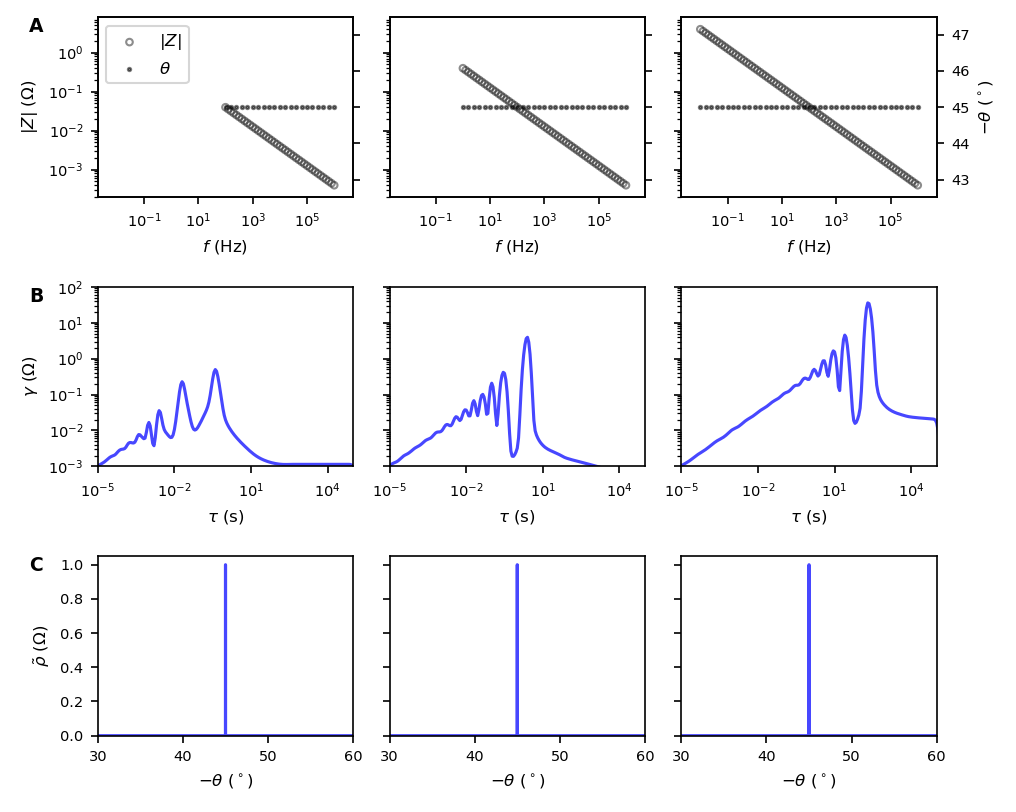

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(full_width, full_width * 0.8))

axes[0, 0].get_shared_x_axes().join(*axes[0])
axes[0, 0].get_shared_y_axes().join(*axes[0])

axes[1, 0].get_shared_x_axes().join(*axes[1])
axes[1, 0].get_shared_y_axes().join(*axes[1])

axes[2, 0].get_shared_x_axes().join(*axes[2])
axes[2, 0].get_shared_y_axes().join(*axes[2])

phase_axes = []
for i in range(len(f_mins)):
    lf = np.log10(f_mins[i])
    f_cpe = np.logspace(6, lf, int(10 * (6 - lf) + 1))
    z_cpe = (1j * f_cpe * 2 * np.pi) ** -0.5
    
    hplt.plot_bode((f_cpe, z_cpe), axes=axes[0, i], cols=['Zmod'], scale_prefix='', **data_kw,
                   label='$|Z|$')
    phase_ax = axes[0, i].twinx()
    phase_axes.append(phase_ax)
    hplt.plot_bode((f_cpe[::2], z_cpe[::2]), axes=phase_ax, cols=['Zphz'], marker='.', c='k',
                   label=r'$\theta$')
    
    drt_fits[i].plot_distribution(ax=axes[1, i], scale_prefix='', c=light_colors[0])
    
    nu_plot = np.unique(np.concatenate((np.linspace(0, -1, 30), [-0.5 - 1e-4, -0.5, -0.5 + 1e-4])))
    dop_fits[i].plot_dop(nu_plot,
                         ax=axes[2, i], scale_prefix='', normalize=True, normalize_tau=(1e0, 1e0),
                         c=light_colors[0])
    
h1, l1 = axes[0, 0].get_legend_handles_labels()
h2, l2 = phase_axes[0].get_legend_handles_labels()
axes[0, 0].legend(handles=h1 + h2, labels=l1 + l2, loc='upper left')
    
for ax in axes[0, 1:]:
    ax.set_ylabel('')
    ax.set_yticklabels([])
for ax in phase_axes[:-1]:
    ax.set_ylabel('')
    ax.set_yticklabels([])
    
for ax in axes[1]:
    ax.set_yscale('log')
    ax.set_xlim(1e-5, 1e5)
    ax.set_ylim(1e-3, 1e2)
for ax in axes[1, 1:]:
    ax.set_ylabel('')
    ax.set_yticklabels([])
    
for ax in axes[2]:
    ax.set_xlim(30, 60)
    ax.set_ylim(0, 1.05)
for ax in axes[2, 1:]:
    ax.set_ylabel('')
    ax.set_yticklabels([])

fig.tight_layout()
ff.add_letters(axes[:, 0], loc=(-0.27, 1.))

# ff.savefig(fig, 'Supp_Nullspace_Warburg_DRT_vs_DOP')

Figure 2. Pure DRT and DOP model application to the Warburg impedance. (A) Simulated Warburg impedance spectra extending to minimum frequencies of 100 Hz, 1 Hz, and 10 mHz (left to right). (B) Pure DRT fits of simulated impedance spectra in A. DRT peaks extend to lower timescales and larger magnitudes as the lowest measured frequency decreases. Note that the y-axis is log-scaled. (C) Pure DOP fits of simulated impedance spectra in A are unaffected by the minimum measured frequency.

## Gerischer

The script `DRT-DOP_separation.py` builds upon this discussion by showing how appropriate regularization of the DRT and DOP can realize the principle of parsimony shown above to prevent the DRT from fitting phasance-type impedance phenomena. Here, we also consider the case in which an RC-type relaxation exhibits nearly-constant-phase behavior over a frequency range before relaxing at lower frequencies, as is the case for the Gerischer element. In this scenario, there should be no ambiguity in the DRT-DOP model (given sufficient data) since the DOP is mathematically incapable of reproducing RC-type relaxations. To verify this, we examine a similar circuit model comprising an ohmic resistance, a ZARC element, and a slightly dispersed Gerischer element (modeled as a Havriliak-Negami element). Impedance spectra were again simulated with fmin ranging from 1 Hz to 10 mHz (Figure 3A below). When fmin=1 Hz, the onset of the Gerischer impedance is nearly constant-phase and shows no sign of RC-type relaxation. Therefore, the DRT-DOP output describes the onset of the Gerischer impedance with a DOP peak at 45° and a small DRT peak at $10^{-1}$ s (left panels of Figures 3B and 3C). This occurs simply because the truncated data is ambiguous – we cannot yet tell if the low-frequency impedance is constant-phase or if it will exhibit RC-type relaxation. However, as soon as the Gerischer impedance begins to relax, as shown for fmin=100 mHz and 10 mHz (Figure 3A), the DRT-DOP model indicates that no constant-phase behavior is present (no DOP peaks, Figure 3C) and correctly identifies the true DRT (Figure 3B). This illustrates that there is no ambiguity in the DRT-DOP model for purely RC-type relaxations so long as the onset of the relaxation is captured in the data

In [13]:
# Make DRT-DOP model instance for fitting Gerischer impedance
dd_ger = DRT(fit_dop=True)


Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready


In [15]:

rng = np.random.default_rng(9329)

dem_ger = DiscreteElementModel('R0-RQ1-HN2')
dem_ger.parameter_values = np.array([
    0.1,
    1.0, np.log(1e-3), 0.7,
    3.0, np.log(1e0), 0.5, 0.95
])

dd_ger_fits = []
drt_ger_fits = []
f_mins = [1, 0.1, 0.01]

# Generate single noise vector for consistency
sigma = 1e-4
n_max = int(10 * (6 - np.log10(f_mins[-1])) + 1)
zn = rng.normal(0, sigma, n_max) + 1j * rng.normal(0, sigma, n_max)

for f_min in f_mins:
    print(f_min)
    lf = np.log10(f_min)
    f_ger = np.logspace(6, lf, int(10 * (6 - lf) + 1))
    
    # Get noisy impedance
    z_ger = dem_ger.predict_z(f_ger)
    z_ger += zn[:len(f_ger)]

    # Fit
    dd_ger.fit_eis(f_ger, z_ger, dop_l2_lambda_0=1)
    dd_ger_fits.append(dd_ger.copy())

1
0.1
0.01


<IPython.core.display.Javascript object>


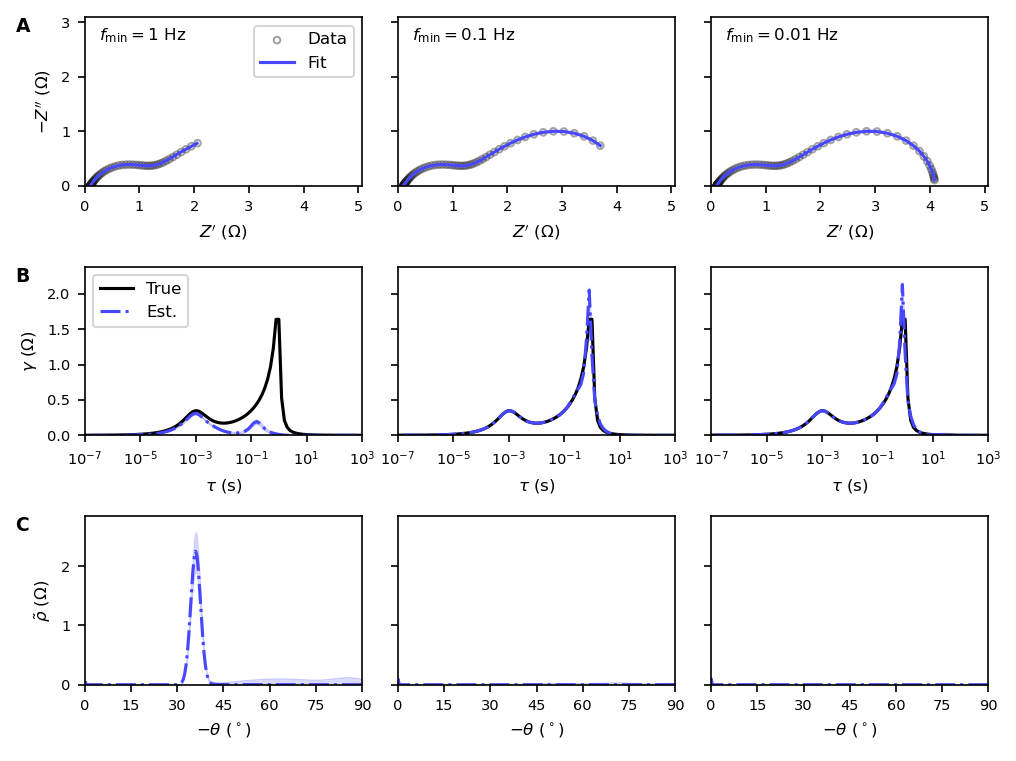

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(full_width, full_width * 0.75))

axes[0, 0].get_shared_x_axes().join(*axes[0])
axes[0, 0].get_shared_y_axes().join(*axes[0])

axes[1, 0].get_shared_x_axes().join(*axes[1])
axes[1, 0].get_shared_y_axes().join(*axes[1])

axes[2, 0].get_shared_x_axes().join(*axes[2])
axes[2, 0].get_shared_y_axes().join(*axes[2])

tau_plot = np.logspace(-8, 3, 111)

for i, fit in enumerate(dd_ger_fits):
    fit.plot_eis_fit(axes=axes[0, i], plot_type='nyquist', data_kw=data_kw | {'alpha': 0.4}, 
                     c=light_colors[0], label='Fit', data_label='Data')
    
    axes[0, i].text(0.05, 0.95, '$f_{{\mathrm{{min}}}}={:3g}$ Hz'.format(f_mins[i]), 
                    transform=axes[0, i].transAxes, ha='left', va='top')
    
    
    dem_ger.plot_distribution(tau_plot, ax=axes[1, i], c='k', scale_prefix='', label='True')
    fit.plot_distribution(ax=axes[1, i], plot_ci=True, scale_prefix='', tau=tau_plot,
                          normalize=False, c=light_colors[0], label='Est.', ls='-.'
                          )
    

    fit.plot_dop(ax=axes[2, i], normalize=True, normalize_tau=(1e0, 1e0), scale_prefix='',
                 plot_ci=True, c=light_colors[0], label='Est.', ls='-.')
    
    

for ax in axes[:, 1:].ravel():
    ax.set_ylabel('')
    ax.set_yticklabels([])
    
for ax in axes[0, 1:]:
    ax.get_legend().remove()
    
for ax in axes[1]:
    ax.set_xlim(1e-7, 1e3)
    ff.zero_axlim(ax,'y')
    # ax.set_ylim(0, 0.35)
    
axes[1, 0].legend()
    
for ax in axes[2]:
    ax.set_xlim(0, 90)
    ax.set_xticks(np.arange(0., 90.1, 15))
    ff.zero_axlim(ax,'y')
    
    
fig.tight_layout()

for ax in axes[0]:
    ff.zero_axlim(ax, 'y')
    hplt.set_nyquist_aspect(ax, 'y')
    
ff.add_letters(axes[:, 0])

# ff.savefig(fig, 'Supp_Nullspace_DRT-DOP_Gerischer')

Figure 3. DRT-DOP application to a ZARC-Gerischer circuit. (A) Simulated impedance spectra with Gaussian noise extending to minimum frequencies of 1 Hz, 100 mHz, and 10 mHz (left to right). (B) DRT estimated by the DRT-DOP model from the spectra in A, overlaid with the true DRT of the circuit.  (C) DOP estimated by the DRT-DOP model from the spectra in A. The true DOP is zero everywhere (the circuit contains no constant-phase elements). In B and C, the shaded region indicates the credible interval of the estimated distribution.